In [1]:
%run ../widgets/config_check.py

In [16]:
# <api>
import numpy as np
from scipy.stats import norm
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
%matplotlib inline

# Load classes and functions from the previous parts
from jupyter_cms.loader import load_notebook
smpl_intro = load_notebook('./Sampling_Intro_WS_Suggestions.ipynb')
smpl_index = load_notebook('./Sampling_Index.ipynb')

In [2]:
smpl_index.help()

# Rejection sampling

The next sampling method is less efficient, but more general in the sense that it can be used even if the normalization constant of the desired density $p(x)$ is unavailable.

It is based on the idea that a sample at position $x$ should be drawn with probability $p(x)$, i.e. the height under the graph of $x$. Thus, a sample can be drawn using two random numbers as follows:

* Draw a sample $x$ from some distribution $q(x)$
* Draw a uniform number $u$ between 0 and $c q(x)$:
  - If $u < p(x)$ return the sample $x$
  - Else discard $x$ and repeat
  
Here, it is assumed that samples from $q(x)$ can be drawn efficiently. Further, the scaling constant $c$ must be choosen such that $c q(x) \geq p(x) \quad \forall x$. The plot below illustrates the idea for the Gaussian distribution:

In [17]:
# <api>
def p(x):
    """
    Unnormalized density of the standard Gaussian
    """
    return np.exp(-0.5*x**2)

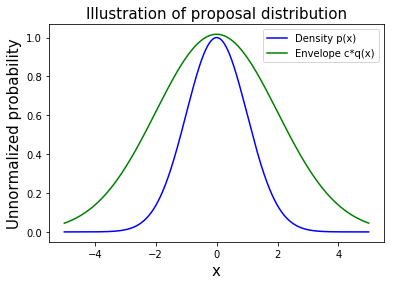

In [25]:
q = norm(loc=0, scale=2)
x = np.arange(-5,5,0.01)
plt.plot(x, p(x), 'b-', x, 5.1*q.pdf(x), 'g-')
plt.xlabel('x', fontsize=15)
plt.ylabel('Unnormalized probability', fontsize=15)
plt.legend(['Density p(x)', 'Envelope c*q(x)'], fontsize=10, loc=1)
plt.title('Illustration of proposal distribution', fontsize=15);

In [19]:
#api
class RejectionSampling (smpl_intro.Sampling):
    def __init__ (self, p, q, c):
        """
        q is assumed to support sampling q.rvs and density evaluation q.pdf
        """
        self.p = p
        self.q = q
        self.c = c
        self.tries = 0
        self.samples = 0
        self.last_approved = [0,0]

    def sample (self):
        while True:
            self.tries += 1
            x = self.q.rvs()
            u = np.random.uniform(low=0, high=self.c*self.q.pdf(x))
            if u < self.p(x):
                self.samples += 1
                return x
            
    def sample_all (self):
        while True:
            self.tries += 1
            x = self.q.rvs()
            u = np.random.uniform(low=0, high=self.c*self.q.pdf(x))
            if u < self.p(x):
                self.samples += 1
                self.last_approved = x
                return [x,x]
            else:
                return [self.last_approved, x]
            
    def __str__ (self):
        return "Rejection sampling: %d tries for %d samples" % (self.tries, self.samples)           

In [21]:
sampling = RejectionSampling(p=p, q=norm(loc=0, scale=2), c=5.1)

smpl_intro.show_sampling(sampling, plotter=smpl_intro.gauss_hist, 
                    f_exp=lambda x: np.power(x,2), true_exp=1.0)
print (sampling)

Output()

Rejection sampling: 1998 tries for 1000 samples


Rejection sampling tends to work well, if a distribution $q(x)$ which closely approximates $p(x)$ from above can be found. Otherwise, the area between the curves will be large leading to a high rejection rate. Especially in high dimensions this is a severe problem.

A standard example to illustrate the difficulties arising in high dimensions is a 2-dimensional Gaussian with high correlation:

In [7]:
# <api>
p2d = multivariate_normal(mean=[0,0], cov=[[1, 0.99],[0.99, 1]])
x = np.linspace(-3, 3, 200)
y = np.linspace(-3, 3, 200)
X, Y = np.meshgrid(x, y)
XY = np.empty(X.shape + (2,))
XY[:,:,0] = X; XY[:,:,1] = Y

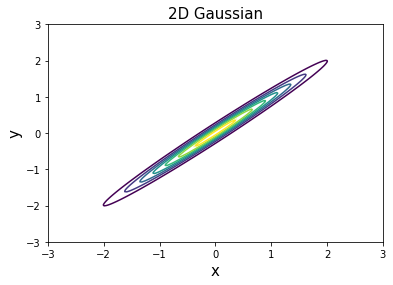

In [26]:
plt.contour(X, Y, p2d.pdf(XY))
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.title('2D Gaussian', fontsize=15);

The problem now is that an isotropic distribution is not a good fit since the above density has two very different length scales. Having a tight fit between the sampling and target density becomes even more important in high dimensions.

For the sake of argument, consider the problem of sampling from a multi-variate Gaussian with mean zero and diagonal covariance matrix $\sigma_p^2 \mathbf{I}_D$ where $\mathbf{I}_D$ denotes the $D \times D$ identity matrix. As a sampling density, we choose another Gaussian with covariance $\sigma_q^2 \mathbf{I}_D$. The condition, $c q \geq p$ now requires that $\sigma_q^2 \geq \sigma_p^2$ and the optimal (smallest) value of $c$ is found to be $\left( \frac{\sigma_p}{\sigma_q} \right)^D$. Then, the acceptance probability is given by the ratio of volumes under $p(x)$ and $c q(x)$ which is just $\frac{1}{c}$ since both distributions are normalized. Thus, the acceptance probability vanishes exponentially in $D$.

**Exercise:** Illustrate this effect when $\sigma_q$ exceeds $\sigma_p$ by $1 \%$.

In [27]:
# <api>
def gauss_hist2d (ax, data, bins):
    x = np.array(data)[:,0]
    y = np.array(data)[:,1]
    im = ax.hist2d(x, y, bins, normed=True)
    ax.xlabel('x', fontsize=15)
    ax.ylabel('y', fontsize=15)
    ax.title("2D histogram of sampled distribution", fontsize=15)

In [28]:
q = multivariate_normal(mean=[0,0], cov=np.eye(2))
sampling = RejectionSampling(p=p2d.pdf, q=q, c=p2d.pdf([0,0])/q.pdf([0,0]))

smpl_intro.show_sampling(sampling, plotter=gauss_hist2d, exp=False)
print(sampling)

Output()

Rejection sampling: 8568 tries for 1000 samples


With a much higher rejection rate as<font color='red'>than?</font> in the 1-dimensional example above.

The next example shows that rejection sampling fails, i.e. samples from the wrong distribution, if the condition $c q(x) \geq p(x)$ is violated: <font color='red'>I don't see how this fails here. Also why is the expectation 1.4?</font>

In [29]:
sampling = RejectionSampling(p=p, q=norm(loc=0, scale=2), c=2)

smpl_intro.show_sampling(sampling, plotter=smpl_intro.gauss_hist, 
                    f_exp=lambda x: np.power(x,2), true_exp=1.4)
print(sampling)

Output()

Rejection sampling: 1402 tries for 1000 samples
